Saving 12-step-1.bmp to 12-step-1.bmp


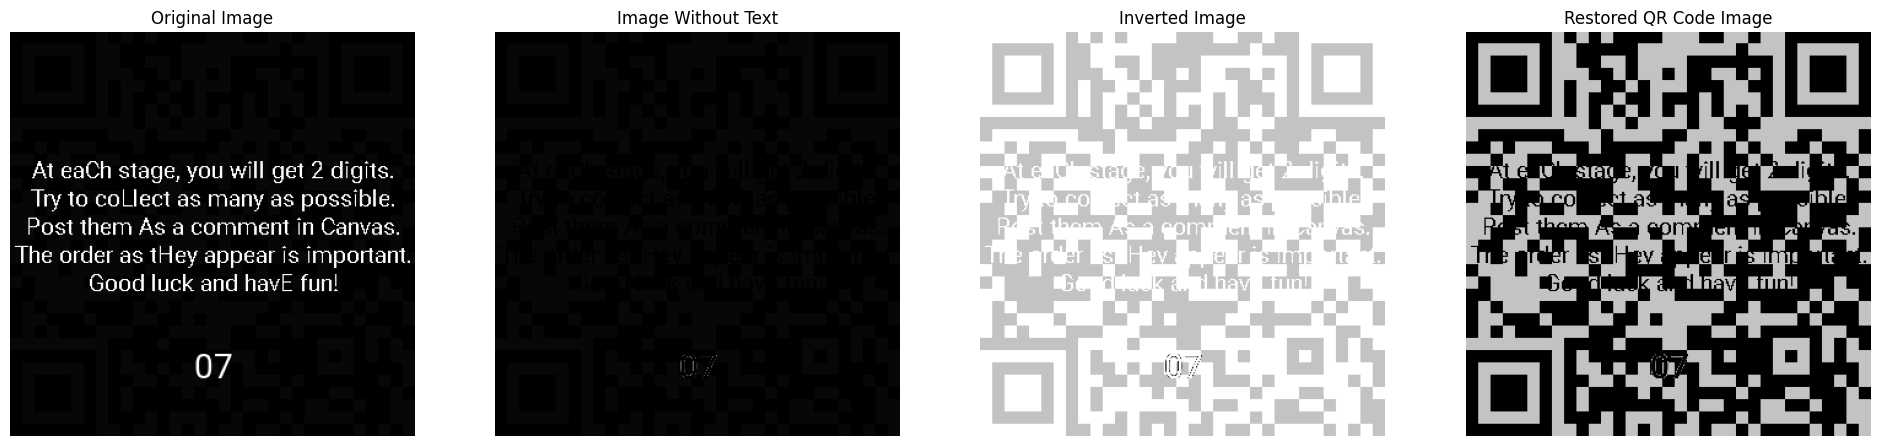

<ipython-input-16-2fad943b4c76>:78: UserWarning: output_image.png is a low contrast image
  io.imsave('output_image.png', masked_image)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
import cv2
from google.colab import files

# Function to remove text from the QR code
def remove_text_from_qr(image):
    # Convert the image to uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to isolate text
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # Invert the image
    inverted_thresh = cv2.bitwise_not(thresh)

    # Overlay the inverted image on the original
    result = cv2.bitwise_and(image, image, mask=inverted_thresh)

    return result

# Upload the image
uploaded = files.upload()

# Get the name of the uploaded file
image_path = list(uploaded.keys())[0]

# Load the image
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Otsu's thresholding to isolate text
threshold_value = filters.threshold_otsu(gray_image)
binary_image = gray_image < threshold_value  # Invert so that text is white on black background

# Create a mask to remove text
masked_image = np.zeros_like(image)
for i in range(3):  # For each RGB channel
    masked_image[..., i] = image[..., i] * binary_image

# Increase brightness and contrast of the image without text
brightened_image = exposure.adjust_gamma(masked_image, gamma=0.5)  # Increase brightness
contrast_enhanced_image = exposure.rescale_intensity(brightened_image, in_range='image', out_range=(0, 1))

# Ensure that the QR code is visible
# Apply inversion to contrast_enhanced_image for better visibility of QR code
inverted_brightened_image = np.clip(1 - contrast_enhanced_image, 0, 1)

# Remove text using OpenCV
final_result = remove_text_from_qr(inverted_brightened_image)

# Display the original and restored images
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(masked_image)
ax[1].set_title('Image Without Text')
ax[1].axis('off')

ax[2].imshow(inverted_brightened_image)
ax[2].set_title('Inverted Image')
ax[2].axis('off')

ax[3].imshow(final_result)
ax[3].set_title('Restored QR Code Image')
ax[3].axis('off')

plt.show()

# Save results
io.imsave('output_image.png', masked_image)
io.imsave('restored_qr_code.png', final_result)

Saving Image 3.bmp to Image 3 (10).bmp


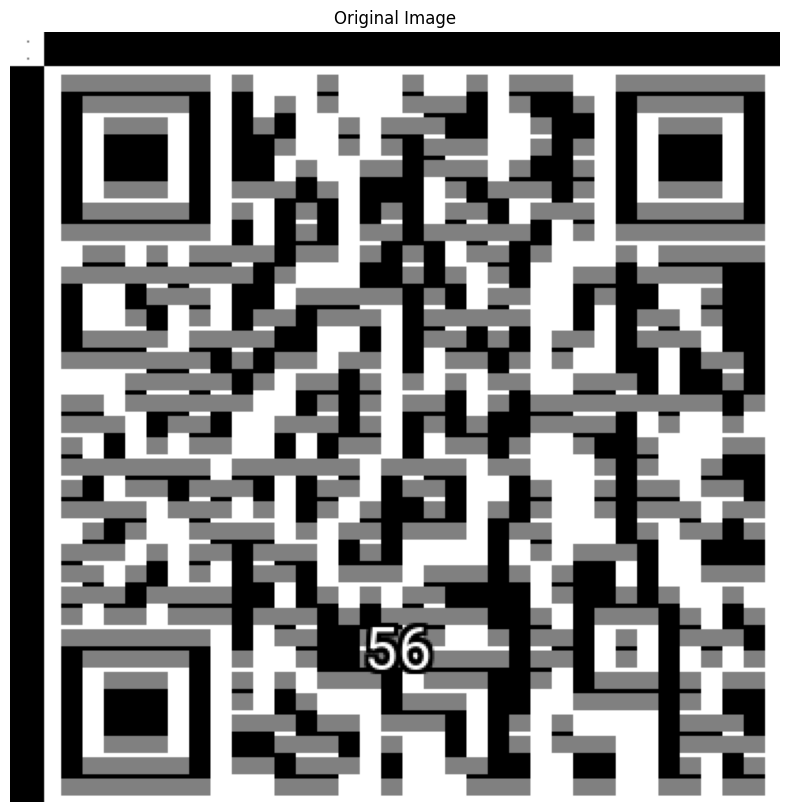

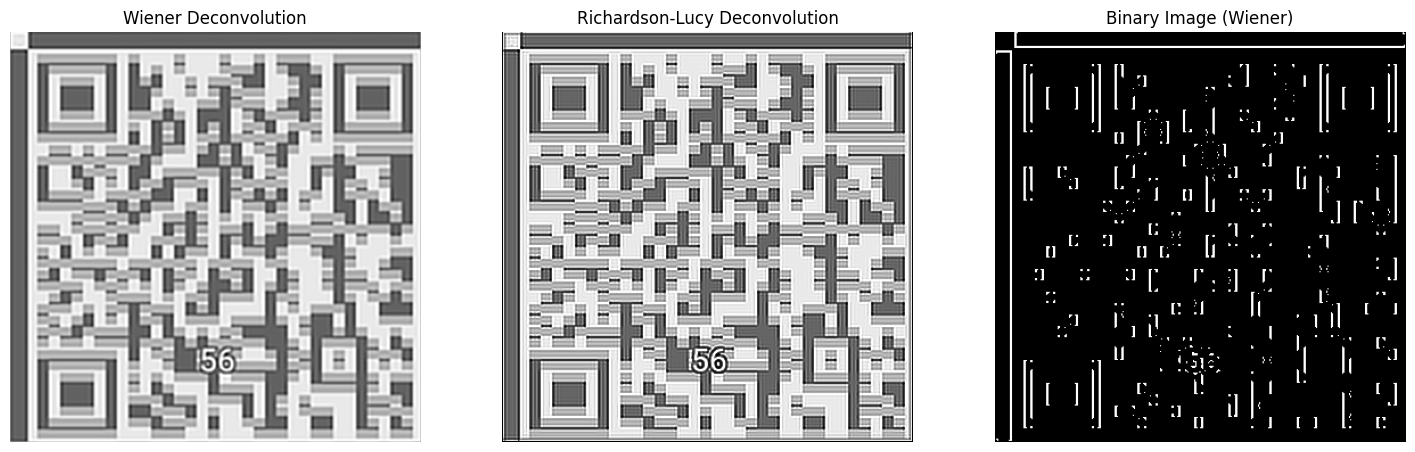

QR Code not found in Wiener deconvolved image.
Blyat


In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import util, exposure, color
from skimage.restoration import wiener, richardson_lucy
from scipy import ndimage as ndi
from google.colab import files

# Load the image
uploaded = files.upload()  # A dialog will open to select a file

# Assuming only one image is uploaded
img_path = list(uploaded.keys())[0]
img = plt.imread(img_path)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Preprocessing the image: Gaussian blur to reduce noise
blurred_image = ndi.gaussian_filter(util.img_as_float(img), sigma=1)  # Adjust sigma for more/less blur

# Sharpening the image using a simple kernel
sharpening_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
sharpened_image = cv2.filter2D(blurred_image, -1, sharpening_kernel)

# Convert to grayscale
gray_image = color.rgb2gray(sharpened_image)

# Rescale intensity to ensure non-negative values
gray_image_rescaled = exposure.rescale_intensity(gray_image, in_range='image', out_range=(0, 1))

# Enhance contrast using gamma correction
enhanced_image = exposure.adjust_gamma(gray_image_rescaled, gamma=0.5)

# Create a Gaussian PSF for deconvolution
sigma = 1.0  # Standard deviation for Gaussian PSF; adjust as needed
size = 5  # Size of the PSF kernel
x = np.linspace(-size // 2 + 1, size // 2, size)
y = np.linspace(-size // 2 + 1, size // 2, size)
x, y = np.meshgrid(x, y)
psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
psf /= psf.sum()  # Normalize the PSF

# Deconvolution using Wiener filter (with balance parameter)
deconvolved_wiener = wiener(enhanced_image, psf, balance=0.1)  # Adjust balance as needed

# Deconvolution using Richardson-Lucy algorithm (using num_iter)
deconvolved_richardson_lucy = richardson_lucy(enhanced_image, psf, num_iter=50)  # Increased iterations

# Binarization of the images (black and white)
binary_image_wiener = deconvolved_wiener < 0.3  # Threshold value can be adjusted
binary_image_richardson = deconvolved_richardson_lucy < 0.3  # Threshold value can be adjusted

# Display the binary images after deconvolution for comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(deconvolved_wiener, cmap='gray')
ax[0].set_title("Wiener Deconvolution")
ax[0].axis('off')

ax[1].imshow(deconvolved_richardson_lucy, cmap='gray')
ax[1].set_title("Richardson-Lucy Deconvolution")
ax[1].axis('off')

ax[2].imshow(binary_image_wiener, cmap='gray')
ax[2].set_title("Binary Image (Wiener)")
ax[2].axis('off')

plt.show()

# QR code detection using OpenCV on the deconvolved images
detector = cv2.QRCodeDetector()

# Detect QR code in Wiener deconvolved image
data_wiener, bbox_wiener, _ = detector.detectAndDecode(binary_image_wiener.astype(np.uint8))

# Check for QR code data and visualize the result for Wiener deconvolution
if data_wiener:
    print("QR Code Data (Wiener):", data_wiener)
    if bbox_wiener is not None:
        for i in range(len(bbox_wiener)):
            cv2.line(img, tuple(bbox_wiener[i][0]), tuple(bbox_wiener[(i + 1) % 4][0]), (255, 0, 0), 3)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title("Detected QR Code (Wiener)")
    plt.axis('off')
    plt.show()
else:
    print("QR Code not found in Wiener deconvolved image.")

# Detect QR code in Richardson-Lucy deconvolved image
data_richardson, bbox_richardson, _ = detector.detectAndDecode(binary_image_richardson.astype(np.uint8))

# Check for QR code data and visualize the result for Richardson-Lucy deconvolution
if data_richardson:
    print("QR Code Data (Richardson-Lucy):", data_richardson)
    if bbox_richardson is not None:
        for i in range(len(bbox_richardson)):
            cv2.line(img, tuple(bbox_richardson[i][0]), tuple(bbox_richardson[(i + 1) % 4][0]), (255, 0, 0), 3)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title("Detected QR Code (Richardson-Lucy)")
    plt.axis('off')
    plt.show()
else:
    print("Blyat")

In [ ]:
#wiener was scaned by me

In [39]:
!sudo apt-get install libzbar0
!pip install pyzbar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-double3
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libjxr-tools libjxr0
  liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x libfftw3-bin libfftw3-dev inkscape poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-

Saving 12-step-3.bmp to 12-step-3.bmp


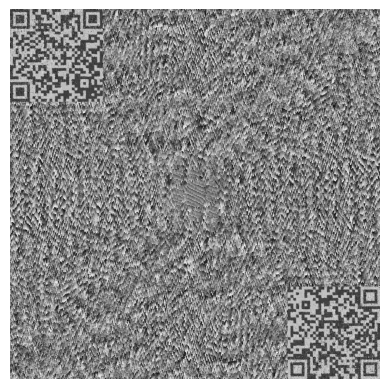

In [43]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload image
uploaded = files.upload()
img_filename = next(iter(uploaded))  # Get the name of the uploaded file

# Load image
img = cv.imread(img_filename)

# Check if the image is loaded correctly
if img is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply FFT and shift zero frequency component to center
    shifted = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img_gray)))

    # Get phase spectrum
    phase_spectrum = np.angle(shifted)

    # Display phase spectrum
    plt.imshow(phase_spectrum, cmap='gray')
    plt.axis('off')  # Turn off axis for cleaner view
    plt.show()

Upload the main image containing QR code pieces:


Saving 12-step-4.bmp to 12-step-4 (24).bmp


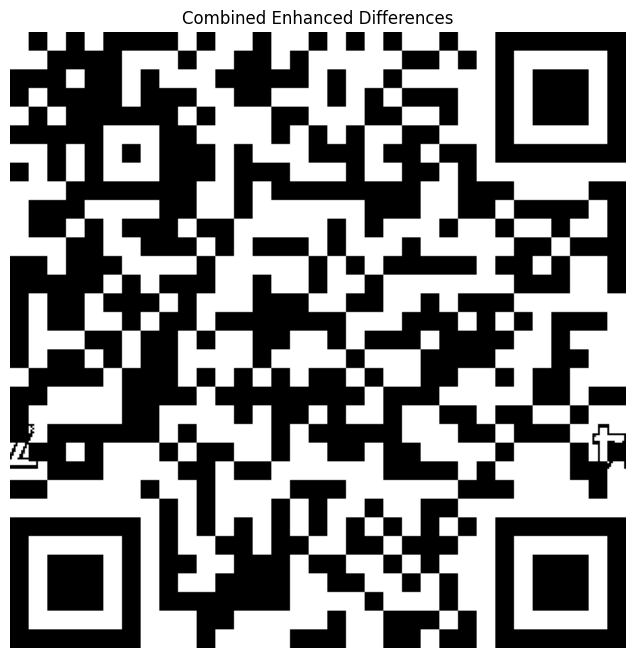

In [15]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload the main image containing QR code pieces
print("Upload the main image containing QR code pieces:")
uploaded = files.upload()

# Load and convert the uploaded image from BGR to RGB
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Split the image into its color channels
b, g, r = cv2.split(image)

# Step 2: Compute the difference between red and blue channels
rb_diff = cv2.absdiff(r, b)

# Step 3: Enhance the difference using CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
rb_diff_enhanced = clahe.apply(rb_diff)

# Step 4: Create a new blank image to place enhanced differences
image_new = np.zeros((330, 330), dtype=np.uint8)

# Place each quadrant in the new image with flipping
image_new[:165, :165] = rb_diff_enhanced[:165, :165][::-1, ::-1]   # Top-left
image_new[165:, :165] = rb_diff_enhanced[165:, :165][::-1, ::-1]   # Bottom-left
image_new[:165, 165:] = rb_diff_enhanced[:165, 165:][::-1, ::-1]   # Top-right
image_new[165:, 165:] = rb_diff_enhanced[165:, 165:][::-1, ::-1]   # Bottom-right

# Step 5: Display the final combined image
plt.figure(figsize=(10, 8))
plt.axis("off")  # Hide axis for better visualization
plt.imshow(image_new, cmap='gray')  # Display in grayscale
plt.title('Combined Enhanced Differences')
plt.show()

SO THERE ARE ALL PHOTOS 07-56-16-74-69